In [26]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [112]:
n_layers = 5
image_size = 512
n_channels = 3
n_embd = image_size
n_t_head = 8
batch_size = 1
block_size = 8
vocab_size = 32
n_t_blocks = 8
n_blocks = 8
n_head = 8
multiplier = 4
eval_iters = 1
learning_rate = 0.1
max_iters = 2

In [51]:
class ConvBlock(nn.Module):

    def __init__(self, n_in, n_out, kernel_size=3, stride=1, padding=0):
        super().__init__()
        self.conv_i = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_c = nn.Conv2d(in_channels=n_out, out_channels=n_out, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()

    def forward(self, idx):
        out = self.conv_i(idx)
        out = self.relu(out)
        out = self.conv_c(out)
        out = self.relu(out)
        return out

In [52]:
class MaxPool(nn.Module):
    
    def __init__(self, kernel_size=2, stride=2):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride)

    def forward(self, idx):
        out = self.maxpool(idx)
        return out

In [53]:
class ExpaBlock(nn.Module):

    def __init__(self, n_in, n_out, kernel_size=2, stride=2, padding=0):
        super().__init__()
        self.layer = nn.ConvTranspose2d(in_channels=n_in, out_channels=n_out, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, idx):
        out = self.layer(idx)
        return out

In [54]:
class Crop(nn.Module):

    def __init__(self, n1, n2):
        super().__init__()
        self.crop = transforms.CenterCrop((n1, n2))

    def forward(self, idx):
        out = self.crop(idx)
        return out

In [55]:
class Decode(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, idx):
        idx = torch.exp(idx/idx.max().clamp(min=1e-5))
        out = idx/idx.max()
        return out

In [56]:
class UNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.contracting_mp = nn.ModuleList([MaxPool() for _ in range(n_layers - 1)])
        self.contracting_conv = nn.ModuleList([ConvBlock(2**(i-1+6) if i else 3, 2**(i+6)) for i in range(n_layers - 1)])
        self.n_conv = ConvBlock(2**(n_layers+4), 2**(n_layers+5))
        self.expanding_uc = nn.ModuleList([ExpaBlock(2**(i+6), 2**(i-1+6)) for i in range(n_layers - 1,0,-1)])
        self.expanding_conv = nn.ModuleList([ConvBlock(2**(i+7), 2**(i-1+7) if i else 3) for i in range(n_layers - 2,-1,-1)])
        self.decode = Decode()

    def forward(self, idx):
        copies = []
        out = idx
        for i in range(len(self.contracting_conv)):
            out = self.contracting_conv[i](out)
            copies.append(out)
            out = self.contracting_mp[i](out)
        out = self.n_conv(out)
        out = F.pad(out, (0, 4, 0, 4))
        for i in range(len(self.expanding_uc)):
            out = self.expanding_uc[i](out)
            A, B = copies[len(copies)-1-i].shape[-2:]
            X, Y = out.shape[-2:]
            A = A + 4 - X + 4
            B = B + 4 - Y + 4
            out = F.pad(out, (0, B, 0, A))
            crop = Crop(out.shape[-2], out.shape[-1])
            out = torch.cat([crop(copies[len(copies)-1-i]), out], dim=1)
            out = self.expanding_conv[i](out)
        out = self.decode(out)
        return out

In [57]:
unet = UNet()
data = unet(torch.randint(0,256,(batch_size,3,image_size,image_size), dtype=torch.float))
data.shape

torch.Size([1, 3, 512, 512])

In [58]:
class TextHead(nn.Module):

    def __init__(self, n_in, head_size):
        
        super().__init__()
        self.p = nn.Linear(n_in, head_size)
        self.k = nn.Linear(n_in, head_size)
        self.v = nn.Linear(n_in, head_size)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, idx):
        (B, T, C) = idx.shape
        
        pos = self.p(idx)
        key = self.k(idx)
        val = self.v(idx)

        wei = pos @ key.transpose(-2,-1)  * key.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))

        wei = F.softmax(wei, dim=-1)

        return wei @ val

In [59]:
class MultiHeadSelfAttention(nn.Module):

    def __init__(self, n_in, n_head):
        super().__init__()
        self.heads = nn.ModuleList([TextHead(n_in, n_in//n_head) for _ in range(n_t_head)])

    def forward(self, idx):
        idx = torch.cat([head(idx) for head in self.heads], dim=-1)
        return idx

In [60]:
class FeedForward(nn.Module):

    def __init__(self, n_in):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(n_in, n_in*multiplier), nn.ReLU(), nn.Linear(n_in*multiplier, n_in))

    def forward(self, idx):
        return self.net(idx)

In [61]:
class TextBlock(nn.Module):

    def __init__(self):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ffwd = FeedForward(n_embd)
        self.mhsa = MultiHeadSelfAttention(n_embd,n_head)

    def forward(self, idx):
        out = self.mhsa(self.ln1(idx)) + idx
        out = self.ffwd(self.ln2(out)) + idx
        return out

In [62]:
class TextModel(nn.Module):

    def __init__(self, n_embd=n_embd):
        super().__init__()
        self.embeedings = nn.Embedding(vocab_size, n_embd)
        self.blocks = nn.Sequential(*[TextBlock() for _ in range(n_t_blocks)])

    def forward(self, idx):
        out = self.embeedings(idx)
        out = self.blocks(out)
        out = out[:,-1,:].view(-1, 1, 1, n_embd)
        out = torch.cat([out.transpose(-2,-1) @ out for _ in range(n_channels)], dim=1)
        return out

In [63]:
t = TextModel()
tdata = t(torch.randint(0, 20, (batch_size, block_size)))
tdata.shape

torch.Size([1, 3, 512, 512])

In [64]:
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.p = nn.Linear(image_size, head_size)
        self.k = nn.Linear(n_embd, head_size)
        self.pi = nn.Linear(image_size, head_size)
        self.ki = nn.Linear(image_size, head_size)
        self.v = nn.Linear(image_size, head_size)
        self.register_buffer('tril', torch.tril(torch.ones(image_size, image_size)))

    def forward(self, idx_i, idx_t, idx_ir):
        (B, C, T, A) = idx_i.shape
        
        pos = self.p(idx_i)
        key = self.k(idx_t)
        key_i = self.ki(idx_ir)
        val = self.v(idx_i)

        wei = pos @ key.transpose(-2,-1)  * key.shape[-1]**-0.5
        
        wei = self.pi(wei)
        wei = wei @ key_i.transpose(-2,-1)  * key.shape[-1]**-0.5
        
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))

        wei = F.softmax(wei, dim=-1)

        return wei @ val

In [65]:
class MultiHeadCrossAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.heads = nn.ModuleList([Head(image_size // n_head) for _ in range(n_head)])
        self.lt = nn.Linear(n_embd, n_embd)
        self.li = nn.Linear(image_size, image_size)
        self.lir = nn.Linear(image_size, image_size)
        self.lo = nn.Linear(image_size, image_size)

    def forward(self, idx_i, idx_t, idx_ir):
        idx_i = idx_i + idx_t + idx_ir
        idx_i = self.li(idx_i)
        idx_t = self.lt(idx_t)
        idx_ir = self.lir(idx_ir)
        idx_i = self.lo(idx_i @ idx_t @ idx_ir)
        idx_i = torch.cat([head(idx_i, idx_t, idx_ir) for head in self.heads], dim=-1)
        return idx_i

In [66]:
class Block(nn.Module):

    def __init__(self):
        super().__init__()
        self.uneti = UNet()
        self.unetir = UNet()
        self.mhca = MultiHeadCrossAttention()
        self.lni = nn.LayerNorm(image_size)
        self.lnt = nn.LayerNorm(n_embd)
        self.lnir = nn.LayerNorm(image_size)

    def forward(self, idx_i, idx_t, idx_ir):
        idx_i = self.lni(idx_i)
        idx_t = self.lnt(idx_t)
        idx_ir = self.lnir(idx_ir)
        idx_ir = self.unetir(idx_ir)
        out = self.uneti(idx_i)
        out = self.mhca(out, idx_t, idx_ir)
        return out

In [85]:
class PreProcess(nn.Module):

        def __init__(self):
            super().__init__()
            self.decoder = Decode()

        def __call__(self, idx):
            B, C, H, W = idx.shape
            
            idx = self.decoder(idx)
            scale = image_size / max(H, W)
            new_H, new_W = int(H * scale), int(W * scale)
            idx = F.interpolate(idx, size=(new_H, new_W), mode='bilinear', align_corners=False)
            
            pad_H = image_size - new_H
            pad_W = image_size - new_W
            pad_top = pad_H // 2
            pad_bottom = pad_H - pad_top
            pad_left = pad_W // 2
            pad_right = pad_W - pad_left
            
            idx = F.pad(idx, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)
            return idx

In [86]:
train_set = [
    [torch.randint(0, 255, (3, 1000, 1000)), 
     torch.randint(0, vocab_size, (block_size,)), 
     torch.randint(0, 255, (3, image_size, image_size))]
    for _ in range(batch_size)
]
val_set = [
    [torch.randint(0, 255, (3, 1000, 1000)), 
     torch.randint(0, vocab_size, (block_size,)), 
     torch.randint(0, 255, (3, image_size, image_size))]
    for _ in range(batch_size)
]

In [87]:
def data_builder(split):
    
    data_set = train_set if split == "train" else val_set
    data = [[] for _ in range(3)]
    
    for point in torch.randint(0, len(data_set), (batch_size,)).tolist():
        for i in range(3):
            data[i].append(data_set[point][i].clone().detach())
        
    for i in range(3):
        data[i] = torch.stack(data[i])

    return data

In [94]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.tm = TextModel()
        self.pre_processor = PreProcess()
        self.blocks = nn.ModuleList([Block() for _ in range(n_blocks)])
        self.decode = Decode()

    def forward(self, idx_t, idx_ir, idx_y=None):
        idx_i= self.pre_processor(torch.randint(0,256,(batch_size,3,image_size,image_size), dtype=torch.float))
        idx_ir = self.pre_processor(idx_ir)
        self.t = self.tm(idx_t)
        out = idx_i
        for block in self.blocks:
            out = block(out, self.t, idx_ir)
        out = self.decode(out)
        if idx_y == None:
            loss = None
        else:
            loss = ((out - decoder(idx_y)) ** 2).mean()
        return out, loss

In [95]:
m = Model()

In [96]:
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

536.862064 M parameters


In [101]:
@torch.no_grad()
def get_loss():
    m.eval()
    decoder = Decode()
    out = {}
    
    for method in ["train", "val"]:
        
        losses = torch.zeros(eval_iters)
        
        for i in range(eval_iters):
            data = data_builder(method)
            res, loss = m(data[1], data[0])
            loss = ((res - decoder(data[2])) ** 2).mean()
            losses[i] = loss
        
        out[method] = losses.mean()
    
    m.train()
    return out

In [102]:
get_loss()

{'train': tensor(0.1100), 'val': tensor(0.1092)}

In [103]:
decoder = Decode()

In [106]:
i = torch.randint(0,255,(batch_size,3,image_size+100,image_size+500), dtype=torch.float)
t = torch.randint(0, 20, (batch_size, block_size))
img, loss = m(t, i)

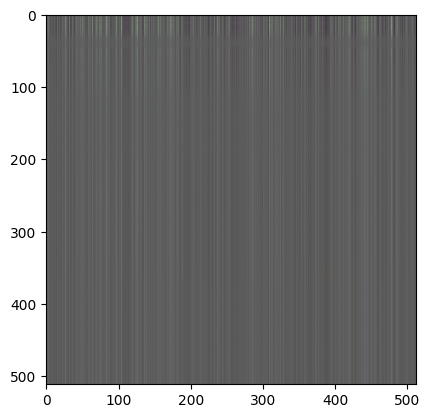

In [107]:
plt.imshow(img[0].permute(1, 2, 0).detach().numpy())

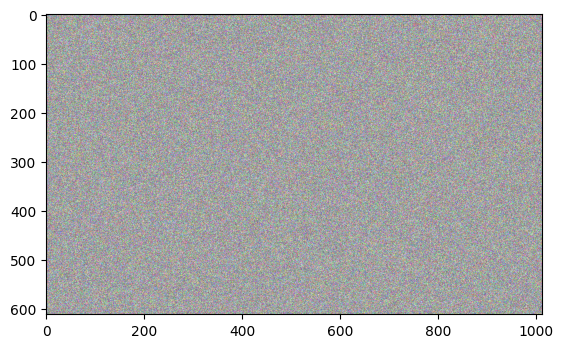

In [108]:
plt.imshow(decoder(i[0]).permute(1, 2, 0).detach().numpy())

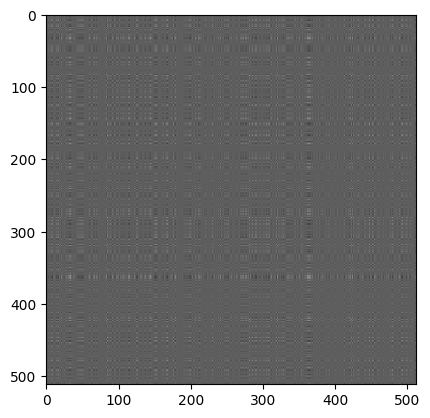

In [109]:
plt.imshow(decoder(m.t[0]).permute(1, 2, 0).detach().numpy())

In [110]:
img[0]

tensor([[[0.3468, 0.4027, 0.4094,  ..., 0.2543, 0.3532, 0.3587],
         [0.3645, 0.3737, 0.3746,  ..., 0.3473, 0.3660, 0.3662],
         [0.3586, 0.3831, 0.3858,  ..., 0.3132, 0.3617, 0.3637],
         ...,
         [0.3643, 0.3741, 0.3751,  ..., 0.3458, 0.3658, 0.3661],
         [0.3643, 0.3740, 0.3750,  ..., 0.3460, 0.3659, 0.3661],
         [0.3644, 0.3740, 0.3750,  ..., 0.3462, 0.3659, 0.3661]],

        [[0.3415, 0.4159, 0.4292,  ..., 0.2197, 0.3480, 0.3622],
         [0.3632, 0.3768, 0.3789,  ..., 0.3341, 0.3641, 0.3663],
         [0.3559, 0.3893, 0.3949,  ..., 0.2906, 0.3586, 0.3649],
         ...,
         [0.3639, 0.3756, 0.3775,  ..., 0.3384, 0.3646, 0.3664],
         [0.3640, 0.3755, 0.3774,  ..., 0.3387, 0.3646, 0.3664],
         [0.3640, 0.3755, 0.3773,  ..., 0.3390, 0.3647, 0.3664]],

        [[0.3529, 0.3941, 0.3970,  ..., 0.2873, 0.3596, 0.3600],
         [0.3657, 0.3722, 0.3725,  ..., 0.3544, 0.3668, 0.3664],
         [0.3607, 0.3805, 0.3818,  ..., 0.3268, 0.3640, 0.

In [113]:
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

In [117]:
for iter in range(max_iters):

    if iter % eval_iters == 0 or iter == max_iters - 1:
        losses = get_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    [idx_ir, idx_t, idx_y] = data_builder('train')

    preds, loss = m(idx_t, idx_ir, idx_y)
    print(loss)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    # if device == "cuda":
    #     torch.cuda.empty_cache()
    # elif device == "mps":
    #     gc.collect()
    #     torch.mps.empty_cache()

step 0: train loss 0.1100, val loss 0.1092
tensor(0.1100, grad_fn=<MeanBackward0>)
step 1: train loss 0.0870, val loss 0.0843
tensor(0.0870, grad_fn=<MeanBackward0>)


In [120]:
img, loss = m(t, i)

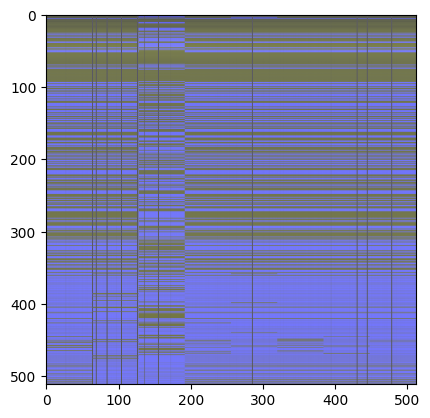

In [121]:
plt.imshow(img[0].permute(1, 2, 0).detach().numpy())

In [122]:
img[0]

tensor([[[0.2910, 0.2915, 0.2911,  ..., 0.2913, 0.2913, 0.2916],
         [0.2910, 0.2915, 0.2911,  ..., 0.2913, 0.2913, 0.2916],
         [0.2910, 0.2915, 0.2911,  ..., 0.2913, 0.2913, 0.2916],
         ...,
         [0.4579, 0.4571, 0.4577,  ..., 0.4574, 0.4575, 0.4571],
         [0.4575, 0.4567, 0.4573,  ..., 0.4570, 0.4571, 0.4567],
         [0.4579, 0.4571, 0.4577,  ..., 0.4574, 0.4575, 0.4570]],

        [[0.3016, 0.3020, 0.3017,  ..., 0.3019, 0.3018, 0.3021],
         [0.3003, 0.3008, 0.3004,  ..., 0.3006, 0.3005, 0.3008],
         [0.3007, 0.3012, 0.3008,  ..., 0.3010, 0.3009, 0.3012],
         ...,
         [0.4687, 0.4678, 0.4685,  ..., 0.4681, 0.4683, 0.4677],
         [0.4682, 0.4673, 0.4680,  ..., 0.4677, 0.4678, 0.4673],
         [0.4686, 0.4677, 0.4684,  ..., 0.4681, 0.4682, 0.4677]],

        [[0.3033, 0.3038, 0.3034,  ..., 0.3036, 0.3035, 0.3038],
         [0.2977, 0.2982, 0.2978,  ..., 0.2980, 0.2979, 0.2982],
         [0.2977, 0.2982, 0.2978,  ..., 0.2980, 0.2979, 0.